# Virtual Try On Eyeglass-2D

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling openc

In [29]:
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import numpy as np

# Step1: Detecting Eye Landmarks from a Static Face Image using Mediapipe

Saving face.jpg to face.jpg


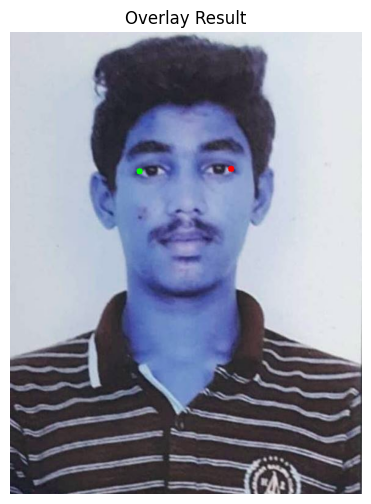

In [31]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Placeholder: Replace "your_face.jpg" with the path to your face image
from google.colab import files
uploaded = files.upload()
from google.colab.patches import cv2_imshow

image = cv2.imread("face.jpg")
# cv2_imshow(image)



# Check if the image was loaded successfully
if image is None:
    print("Error: Could not load image. Please ensure 'your_face.jpg' exists in the correct directory.")
else:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            h, w, _ = image.shape
            left_eye = face_landmarks.landmark[33]  # Left eye corner
            right_eye = face_landmarks.landmark[263]  # Right eye corner

            x1, y1 = int(left_eye.x * w), int(left_eye.y * h)
            x2, y2 = int(right_eye.x * w), int(right_eye.y * h)

            cv2.circle(image, (x1, y1), 5, (0, 255, 0), -1)
            cv2.circle(image, (x2, y2), 5, (255, 0, 0), -1)

    # cv2.imshow("Eyes", image)
    # cv.waitkey(0)

    # Display in notebook using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title("Overlay Result")
    plt.show()

In [32]:
print(f'left_eye: {left_eye}, right_eye: {right_eye}')

left_eye: x: 0.369104028
y: 0.30138433
z: 0.0396098681
, right_eye: x: 0.628983
y: 0.296815634
z: 0.0411591344



# Step2: Transform Glasses According to Eye Landmarks

In [33]:
def transform_glasses(glasses_img, left_eye, right_eye, nose_bottom):
    # Step 1: Compute eye distance
    eye_distance = np.linalg.norm(np.array(right_eye) - np.array(left_eye))

    # Step 2: Widen the glasses width to simulate temples
    temple_extension = 0.3  # Extend by 30% on each side
    extended_distance = eye_distance * (1 + 2 * temple_extension)
    glasses_width = int(extended_distance)

    # Step 3: Resize glasses
    resized = cv2.resize(glasses_img, (glasses_width, int(glasses_img.shape[0] * (glasses_width / glasses_img.shape[1]))))

    # Step 4: Compute angle between eyes
    delta_y = right_eye[1] - left_eye[1]
    delta_x = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    # Step 5: Rotate the glasses
    (h, w) = resized.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(resized, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    # Step 6: Compute mid-eye center for placement (still between original eyes)
    mid_x = (left_eye[0] + right_eye[0]) // 2
    mid_y = (left_eye[1] + right_eye[1]) // 2

    return rotated, (mid_x, mid_y)


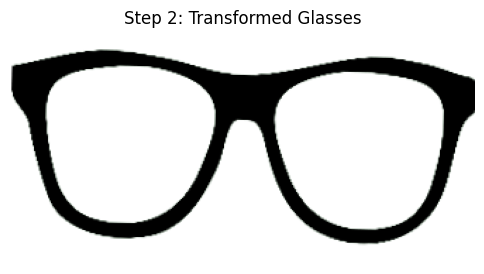

In [34]:
# Load and transform glasses

glasses = cv2.imread("eyeglass.png", cv2.IMREAD_UNCHANGED)
eye_width = int(np.linalg.norm([x2 - x1, y2 - y1]) * 2.2)
angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

resized = cv2.resize(glasses, (eye_width, int(glasses.shape[0] * eye_width / glasses.shape[1])))
M = cv2.getRotationMatrix2D((resized.shape[1] // 2, resized.shape[0] // 2), angle, 1.0)
rotated = cv2.warpAffine(resized, M, (resized.shape[1], resized.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

# Show transformed glasses
plt.figure(figsize=(6, 5))
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
plt.title("Step 2: Transformed Glasses")
plt.show()


# Step3: Overlaying Glasses on the Face

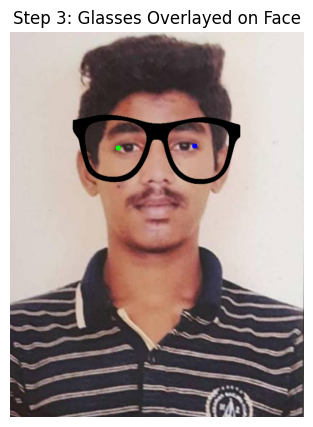

In [35]:
def overlay_transparent(background, overlay, x, y):
    bh, bw = background.shape[:2]
    h, w = overlay.shape[:2]

    if x < 0 or y < 0 or x + w > bw or y + h > bh:
        return background

    overlay_img = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_img
    return background.astype(np.uint8)

center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
x_offset = center_x - rotated.shape[1] // 2
y_offset = center_y - rotated.shape[0] // 2 + 5

overlayed_img = overlay_transparent(image.copy(), rotated, x_offset, y_offset)

# Show final overlay
plt.figure(figsize=(6, 5))
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Step 3: Glasses Overlayed on Face")
plt.show()


# Step 4: Final Integration – Detect Eyes, Transform & Overlay Eyeglasses on Face Image

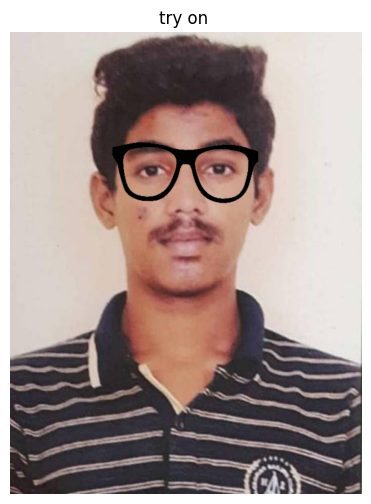

In [36]:
import math

# Load eyeglass PNG (with alpha channel)
glasses_img = cv2.imread("eyeglass.png", cv2.IMREAD_UNCHANGED)

# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Load input image
img = cv2.imread("face.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Detect facial landmarks
results = face_mesh.process(rgb)
if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0].landmark

    # Eye indices (using MediaPipe's landmark schema)
    LEFT_EYE = landmarks[33]
    RIGHT_EYE = landmarks[263]

    x1, y1 = int(LEFT_EYE.x * w), int(LEFT_EYE.y * h)
    x2, y2 = int(RIGHT_EYE.x * w), int(RIGHT_EYE.y * h)

    # Midpoint & distance between eyes
    mid_x = (x1 + x2) // 2
    mid_y = (y1 + y2) // 2
    distance = int(math.hypot(x2 - x1, y2 - y1))
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))


    left_eye = (int((landmarks[33].x) * w), int(landmarks[33].y * h))
    right_eye = (int((landmarks[263].x) * w), int(landmarks[263].y * h))


# Get transformed eyeglasses
    glasses_transformed,(a,b) = transform_glasses(glasses_img, left_eye, right_eye,1.6)
    x = mid_x - glasses_transformed.shape[1] // 2
    y = mid_y - glasses_transformed.shape[0] // 2 + 5

    output = overlay_transparent(img.copy(), glasses_transformed, x, y)
    output=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(output)
    plt.axis('off')  # Hide axes
    plt.title("try on ")
    plt.show()




else:
    print("No face detected.")


# Real-Time Virtual Eyeglass Try-On using Mediapipe and OpenCV

In [12]:




# Load eyeglass image with alpha channel (transparency)
glasses = cv2.imread("eyeglass2.png", cv2.IMREAD_UNCHANGED)

# Initialize mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)
mp_drawing = mp.solutions.drawing_utils

# Function to overlay transparent image
def overlay_transparent(background, overlay, x, y):
    bh, bw = background.shape[:2]
    h, w = overlay.shape[:2]

    if x + w > bw or y + h > bh:
        return background

    overlay_img = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_img
    return background

# Function to place glasses based on landmarks
def apply_glasses(frame, landmarks, glasses_img):
    ih, iw, _ = frame.shape
    left_eye = landmarks[33]  # or 133
    right_eye = landmarks[263]  # or 362

    x1, y1 = int(left_eye.x * iw), int(left_eye.y * ih)
    x2, y2 = int(right_eye.x * iw), int(right_eye.y * ih)

    eye_width = int(np.linalg.norm([x2 - x1, y2 - y1]) * 2.2)
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    resized_glasses = cv2.resize(glasses_img, (eye_width, int(glasses_img.shape[0] * eye_width / glasses_img.shape[1])))

    # Rotate glasses
    M = cv2.getRotationMatrix2D((resized_glasses.shape[1] // 2, resized_glasses.shape[0] // 2), angle, 1.0)
    rotated = cv2.warpAffine(resized_glasses, M, (resized_glasses.shape[1], resized_glasses.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

    y_offset = center_y - rotated.shape[0] // 2
    x_offset = center_x - rotated.shape[1] // 2

    return overlay_transparent(frame, rotated, x_offset, y_offset)

# Real-time webcam capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(frame_rgb)

    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            landmark_points = face_landmarks.landmark
            frame = apply_glasses(frame, landmark_points, glasses)

    cv2.imshow("Virtual Eyeglass Try-On", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()